# 1. EDA

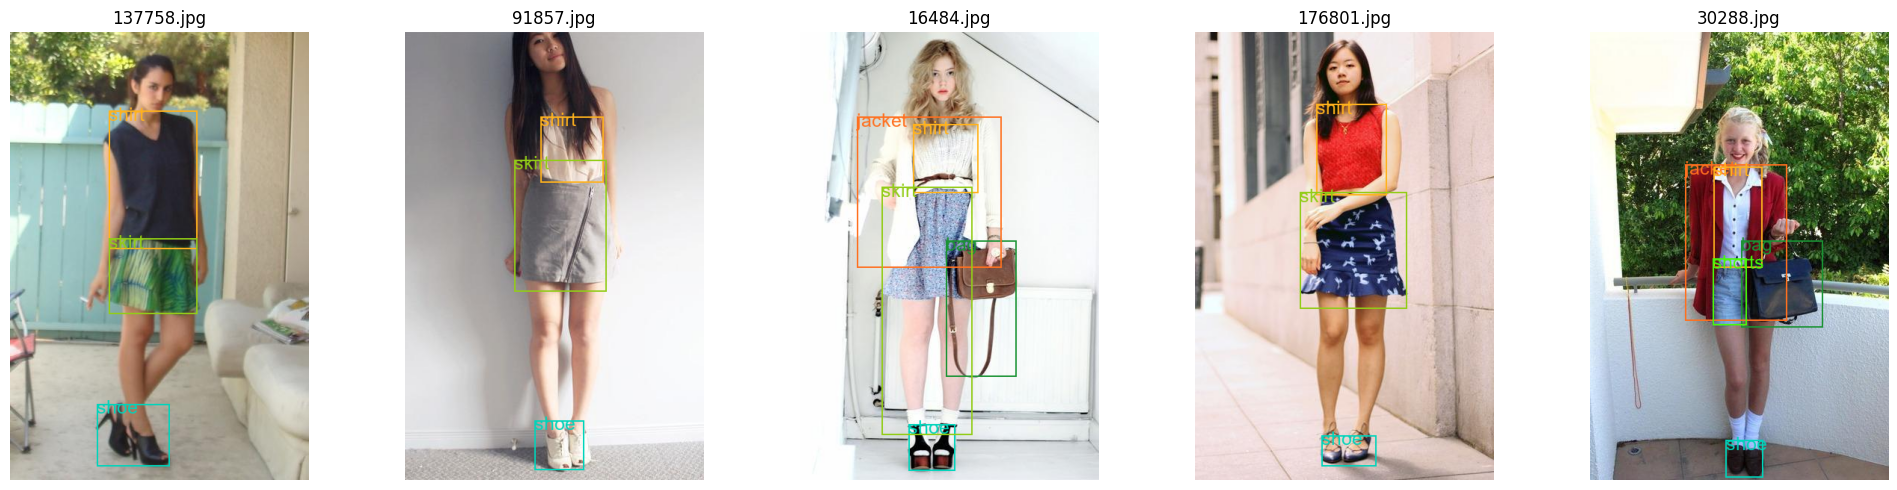

In [18]:
import os
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Definieer de paden naar de data
base_path = 'transforming-fashion-2025\\Dataset'
image_dir = os.path.join(base_path, 'Train', 'images')
label_dir = os.path.join(base_path, 'Train', 'labels')

# Definieer de klassenamen zoals gespecificeerd in de opdracht 
class_names = {
    0: 'sunglass', 1: 'hat', 2: 'jacket', 3: 'shirt', 4: 'pants',
    5: 'shorts', 6: 'skirt', 7: 'dress', 8: 'bag', 9: 'shoe'
}

# Kleuren voor de bounding boxes per klasse
# We gebruiken een lijst met kleuren om elke klasse een unieke kleur te geven
colors = ['#FF3838', '#FF9D97', '#FF701F', '#FFB21D', '#CFD231', '#48F90A', '#92CC17', '#3DDB86', '#1A9334', '#00D4BB']

# Fontsize bepalen
font = ImageFont.truetype("arial.ttf", size=25)

# Haal een lijst op van alle afbeeldingen en selecteer er 5 willekeurig
all_images = os.listdir(image_dir)
selected_images = random.sample(all_images, 5)

# Maak een plot om de afbeeldingen weer te geven
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, image_name in enumerate(selected_images):
    # Bouw de volledige paden naar de bestanden
    image_path = os.path.join(image_dir, image_name)
    
    # De naam van het labelbestand is gelijk aan de afbeeldingsnaam, maar met .txt extensie 
    label_name = os.path.splitext(image_name)[0] + '.txt'
    label_path = os.path.join(label_dir, label_name)

    # Laad de afbeelding
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    img_width, img_height = img.size

    # Verwerk het labelbestand
    with open(label_path, 'r') as f:
        # Elke rij in het bestand is een object 
        for line in f.readlines():
            parts = line.strip().split()
            
            # Lees de data uit de regel
            class_id = int(parts[0])
            center_x_norm = float(parts[1])
            center_y_norm = float(parts[2])
            width_norm = float(parts[3])
            height_norm = float(parts[4])

            # De-normaliseer de coördinaten naar pixelwaarden 
            center_x = center_x_norm * img_width
            center_y = center_y_norm * img_height
            box_width = width_norm * img_width
            box_height = height_norm * img_height

            # Bereken de hoekpunten van de bounding box
            # (x_min, y_min) is de linkerbovenhoek, (x_max, y_max) de rechteronderhoek
            x_min = center_x - (box_width / 2)
            y_min = center_y - (box_height / 2)
            x_max = center_x + (box_width / 2)
            y_max = center_y + (box_height / 2)
            
            # Teken de bounding box
            draw.rectangle([x_min, y_min, x_max, y_max], outline=colors[class_id], width=2)
            
            # Voeg de klassenaam als label toe
            label_text = class_names[class_id]
            draw.text((x_min, y_min - 10), label_text, font=font, fill=colors[class_id])

    # Toon de afbeelding in de subplot
    axs[i].imshow(img)
    axs[i].set_title(image_name)
    axs[i].axis('off')

# Toon de volledige plot
plt.tight_layout()
plt.show()

# 2. Objectdetectie

## 2.1 Inleiding
Voor deze opdracht wordt YOLOv8 (You Only Look Once, versie 8) gebruikt. Dit is een
state-of-the-art, real-time objectdetectiemodel dat bekend staat om zijn snelheid en
hoge nauwkeurigheid. We gebruiken een voorgetraind model ('yolov8n.pt'), dat al
getraind is op de grote COCO-dataset. Door dit model te 'fine-tunen' op onze
fashion-dataset, kan het met relatief weinig trainingstijd leren om de specifieke
kledingstukken te herkennen.

## 2.2 Hoe het model voorspellingen doet
Het YOLOv8-model doet voorspellingen in één enkele pass door het neurale netwerk,
vandaar de naam 'You Only Look Once'. Het proces kan als volgt worden samengevat
(Jocher et al., 2023):
1. Input & Backbone: De input-afbeelding wordt eerst door een 'backbone'-netwerk
   (CSPDarknet53) gestuurd. Deze backbone extraheert op verschillende schalen
   'feature maps'. Dit zijn representaties van de afbeelding waarin belangrijke
   visuele kenmerken (zoals randen, texturen, vormen) zijn vastgelegd.
2. Neck: De feature maps van de backbone gaan vervolgens naar de 'neck'
   (een PANet-structuur). De neck combineert de feature maps van verschillende
   schalen. Dit helpt het model om zowel kleine als grote objecten goed te
   detecteren.
3. Head (Detectie): De 'head' van het model is verantwoordelijk voor de uiteindelijke
   voorspellingen. YOLOv8 is 'anchor-free'. In plaats van vooraf gedefinieerde
   'anchor boxes' te gebruiken, voorspelt de head direct het middelpunt, de
   hoogte en breedte van een object. Voor elke locatie in de feature map voorspelt
   de head:
   - Een class-score voor elk van de 10 klassen (shirt, tas, etc.).
   - De coördinaten en afmetingen van de bounding box.
4. Output: Na een non-maximum suppression (NMS) stap, die overlappende bounding
   boxes voor hetzelfde object wegfiltert, blijven de definitieve detecties over.

## 2.3 Hoe de afbeeldingen worden voorbewerkt (Preprocessing & Augmentation)
De `ultralytics` library handelt de voorbewerking en data-augmentatie automatisch
af tijdens de training. Dit is een cruciaal proces voor het behalen van goede
resultaten en het voorkomen van overfitting.

Voorbewerking:
- Resizing: Alle afbeeldingen worden naar een vaste grootte geschaald,
  gespecificeerd door de hyperparameter `imgsz` (in ons geval 640x640 pixels).
- Normalisatie: De pixelwaarden (0-255) worden genormaliseerd naar een schaal
  van 0.0 tot 1.0. Dit is een standaardprocedure die de training stabiliseert.

Data Augmentatie:
Tijdens de training worden willekeurige aanpassingen op de afbeeldingen toegepast.
Hierdoor 'ziet' het model elke afbeelding steeds in een iets andere vorm, wat helpt
om een robuuster model te trainen (Jocher et al., 2023). Standaard past YOLOv8 o.a.
de volgende augmentaties toe:
- Kleurruimte aanpassingen (Hue, Saturation, Value).
- Horizontaal spiegelen (`fliplr`).
- Schalen en transleren.

## 2.4 Feature Engineering
Bij het gebruik van diepe neurale netwerken zoals YOLOv8 is traditionele, handmatige
'feature engineering' niet van toepassing. De kracht van deep learning modellen ligt
juist in het feit dat ze hiërarchische features zelfstandig leren uit de data
(LeCun et al., 2015). De convolutionele lagen in de 'backbone' functioneren als
automatische feature extractors:
- De eerste lagen leren simpele features zoals randen en kleuren.
- Diepere lagen combineren deze om complexere patronen te herkennen, zoals
  stoffen, knopen, of de vorm van een broekspijp.
Onze taak is dus niet het ontwerpen van features, maar het correct aanleveren van
gelabelde data en het juist configureren van het trainingsproces.

## 2.5 Onderbouwing van Hyperparameters, Optimizer en Epochs 
De keuzes hieronder zijn een balans tussen prestaties en trainingstijd.
- `data`: 'data.yaml'. Dit is het configuratiebestand
  dat we eerder hebben gemaakt. Het vertelt het model waar de data staat en wat
  de klassen zijn.
- `epochs`: 100. Een epoch is één volledige doorgang over de gehele trainingsdataset.
  100 epochs is een solide startpunt. Door 'patience' te gebruiken, zal de
  training eerder stoppen als het model niet meer verbetert, wat overbodige
  trainingstijd voorkomt.
- `patience`: 20. Dit is voor 'early stopping'. Als de mAP@0.5 score (de primaire
  evaluatiemetriek) op de validatieset 20 epochs lang niet verbetert, wordt de
  training automatisch gestopt. Dit voorkomt overfitting en slaat het best
  presterende model op.
- `batch`: 16. Dit is het aantal afbeeldingen dat tegelijk door het netwerk wordt
  verwerkt. 16 is een gangbare waarde die vaak goed past op moderne GPU's. Een
  grotere batch size kan de training versnellen, maar vereist meer VRAM.
- `imgsz`: 640. De invoerafbeeldingen worden naar 640x640 pixels geschaald. Dit
  is een standaard en effectieve resolutie voor YOLO-modellen.
- `optimizer`: 'AdamW'. Hoewel de `ultralytics` library zelf de optimizer kiest
  (standaard 'AdamW'), is dit een uitstekende keuze. AdamW (Adaptive Moment
  Estimation with Weight Decay) is een variant van de populaire Adam-optimizer die
  'weight decay' op een effectievere manier toepast, wat vaak leidt tot betere
  generalisatie en dus een beter presterend model (Loshchilov & Hutter, 2019).

## 2.6 De Loss Functie 
De totale loss van het model is een som van drie componenten. De loss-functie
berekent het verschil tussen de voorspelling van het model en de ware labels, en
stuurt het leerproces door dit verschil te minimaliseren (Jocher et al., 2023).
1. Box Loss (Regressie Loss): Deze berekent de fout in de locatie en grootte van
   de voorspelde bounding box. YOLOv8 gebruikt 'Complete IoU' (CIoU) loss. Deze
   houdt niet alleen rekening met de overlap (Intersection over Union), maar ook
   met de afstand tussen de middelpunten en het verschil in beeldverhouding.
   Daarnaast wordt 'Distribution Focal Loss' (DFL) gebruikt om de continue
   locaties van de box te leren als een discrete distributie, wat de precisie
   verhoogt.
2. Class Loss (Classificatie Loss): Deze berekent hoe goed het model de juiste
   klasse voorspelt (bv. 'shirt' vs 'broek'). Hiervoor wordt 'Binary Cross-Entropy'
   (BCE) gebruikt. Deze meet de fout voor elke klasse afzonderlijk.
De gewogen som van deze losses vormt de uiteindelijke loss-waarde die het model
tijdens de training probeert te minimaliseren.

In [1]:
from ultralytics import YOLO

# We laden 'yolov8n.pt'. 'n' staat voor 'nano', de kleinste en snelste variant van
# YOLOv8. Dit is een goede keuze voor een snelle start en vereist minder
# rekenkracht, terwijl het toch sterke prestaties levert.
model = YOLO('yolov8n.pt')

# De `train` functie start het volledige trainingsproces.
# De resultaten, inclusief de getrainde modelgewichten en prestatiegrafieken,
# worden automatisch opgeslagen in een nieuwe map, meestal `runs/detect/train`.
results = model.train(
    data='data.yaml',
    epochs=1,
    patience=20,
    batch=16,
    imgsz=640,
    optimizer='AdamW'
)

# Na de training bevat de map `runs/detect/train` alle
# belangrijke resultaten:
# - `weights/best.pt`: Dit is het model met de beste prestaties op de validatieset.
#   Dit model gebruik je voor je uiteindelijke voorspellingen op de testset.
# - `results.csv`: Een logboek met de metrics per epoch (loss, mAP, etc.).
# - `confusion_matrix.png`: Een visuele weergave van de classificatieprestaties.
# - `val_batch0_pred.jpg`: Voorbeelden van voorspellingen op de validatieset.
# Je kunt `results.csv` inlezen met pandas om de leercurves te plotten, of de
# automatisch gegenereerde grafieken in de map bekijken.

print("Training voltooid.")
print("De resultaten zijn opgeslagen in de map 'runs/detect/'.")
print("Het beste model is te vinden in 'runs/detect/trainX/weights/best.pt'.")

c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\larsl\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.155  Python-3.11.1 torch-2.6.0+cpu CPU (Intel Core(TM) i7-10750H 2.60GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.

train: Scanning C:\Users\larsl\Documents\Github\DeepLearning\Opdracht 3\transforming-fashion-2025\Dataset\Train\labels... 2145 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2145/2145 [00:01<00:00, 1523.92it/s]


train: New cache created: C:\Users\larsl\Documents\Github\DeepLearning\Opdracht 3\transforming-fashion-2025\Dataset\Train\labels.cache
val: Fast image access  (ping: 0.10.0 ms, read: 302.7104.0 MB/s, size: 41.5 KB)


val: Scanning C:\Users\larsl\Documents\Github\DeepLearning\Opdracht 3\transforming-fashion-2025\Dataset\Train\labels.cache... 2145 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2145/2145 [00:00<?, ?it/s]


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train4
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.631      2.287      1.589          9        640: 100%|██████████| 135/135 [13:39<00:00,  6.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [04:32<00:00,  4.01s/it]


                   all       2145       8298      0.261       0.26      0.139     0.0668

1 epochs completed in 0.304 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 6.2MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics 8.3.155  Python-3.11.1 torch-2.6.0+cpu CPU (Intel Core(TM) i7-10750H 2.60GHz)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 68/68 [04:01<00:00,  3.55s/it]


                   all       2145       8298       0.26       0.26      0.139     0.0667
              sunglass        343        343          1          0     0.0421     0.0108
                   hat        273        273      0.226      0.234      0.142       0.05
                jacket        765        777          0          0     0.0133    0.00715
                 shirt       1461       1486      0.174       0.07       0.06      0.023
                 pants        508        508      0.365      0.123       0.15     0.0833
                shorts        395        395     0.0283      0.729      0.199       0.11
                 skirt        697        697      0.349      0.458       0.29       0.17
                 dress        550        550     0.0188     0.0782     0.0126    0.00587
                   bag       1188       1188     0.0624      0.456      0.117     0.0507
                  shoe       2081       2081      0.378      0.453      0.362      0.157
Speed: 1.8ms preproce

# Literatuurlijst
- Jocher, G., Chaurasia, A., & Qiu, J. (2023). *YOLO by Ultralytics*. GitHub. https://github.com/ultralytics/ultralytics
- LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. *Nature*, *521*(7553), 436–444. https://doi.org/10.1038/nature14539
- Loshchilov, I., & Hutter, F. (2019). Decoupled weight decay regularization. *arXiv preprint arXiv:1711.05101*. https://arxiv.org/abs/1711.05101